## Import libraires and data, set up stuff

In [171]:
import anndata as ad
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from IPython.display import Markdown, display
from IPython.core.display import display, HTML
from os import environ

sns.set_context('poster')
plt.style.use('seaborn-darkgrid')

display(HTML("<style>.container { width:90% !important; }</style>"))
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80) #resolution

/scratch/15246440/ipykernel_35254/4071164959.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/scratch/15246440/ipykernel_35254/4071164959.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Functions

In [172]:
# all sample matrices in one matrix
def get_adata(path_to_mtx,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [173]:
def get_adata_velocyto(path_to_mtx,path_to_velocyto,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    ldata = sc.read_loom(path_to_velocyto[0])
    adata = scv.utils.merge(adata,ldata)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        ldata = sc.read_loom(path_to_velocyto[idx+1])
        adata_new = scv.utils.merge(adata_new,ldata)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [174]:
# add variable for chomosome
def add_chroms(adata,chroms_df):
    chroms_df = chroms_df[chroms_df["gene_id"].isin(adata.var_names)].copy()
    adata = adata[:,chroms_df["gene_id"]].copy()
    adata.var["chromosome"] = chroms_df["CHROM"].tolist()
    return adata

In [175]:
def get_unspliced_spliced(adata,adata_spliced,adata_unspliced):
    adata_spliced = adata_spliced[adata.obs_names,:].copy()
    adata_spliced = adata_spliced[:,adata.var_names].copy()
    adata.layers["spliced"] = adata_spliced.X
    
    adata_unspliced = adata_unspliced[adata.obs_names,:].copy()
    adata_unspliced = adata_unspliced[:,adata.var_names].copy()
    adata.layers["unspliced"] = adata_unspliced.X
    
    return adata

In [176]:
def get_ampl_counts(adata):
    amplicons = [x for x in adata.var_names if x.startswith("amplicon")]
    sc_genes = [x for x in adata.var_names if not x.startswith("amplicon")]
    adata_sc = adata[:,sc_genes].copy()
    adata_amplicons = adata[:,amplicons].copy()
    adata_amplicons.var["family"] = ["_".join(x.split("_")[:-1]) for x in amplicons]
    family_counts_dict = {}
    for x in np.unique(adata_amplicons.var["family"]):
        family_counts_dict[x] = np.sum(adata_amplicons[:,adata_amplicons.var["family"]==x].X,axis=1).A1.tolist()
    family_counts_df = pd.DataFrame(family_counts_dict,index=adata_amplicons.obs_names)
    adata_amplicons_fam = sc.AnnData(family_counts_df)
    print(family_counts_dict.keys())
    adata_new = ad.concat([adata_sc,adata_amplicons_fam],axis=1,join='outer',merge="only")
    return adata_new

In [177]:
def plotQC(adata):
    """
    Function for plotting QC values. 
    Needs to run preprocess.calculateQC first.
    """
    from scipy.sparse import issparse
    import scanpy as sc
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import pandas as pd
    import numpy as np
    import seaborn as sns


    df=pd.DataFrame(index=adata.obs_names)
    df['total_counts'] = adata.obs['total_counts']
    df['n_genes_per_cell'] = adata.obs['n_genes_by_counts']
    if 'percent_mito' in adata.obs_keys():
        df['percent_mito'] = adata.obs['percent_mito']
    else:
        df['percent_mito'] = np.zeros(adata.shape[0])

    plt.rcParams['figure.figsize']=(20,20)
    f, ax = plt.subplots(3,2)

    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='percent_mito', data=df, ax=ax[0,0])
    ax[0,0].set_title('UMI vs GENES plot - percent mito genes')

    if 'prop_spl' in adata.obs_keys():
        df['rate_spliced'] = adata.obs['prop_spl']
    else:
        df['rate_spliced'] = np.zeros(adata.shape[0])
    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='rate_spliced', data=df, ax=ax[0,1])
    ax[0,1].set_title('UMI vs GENES plot - spliced proportions')
    # changed distplot to histplot
    sns.histplot(df['total_counts'], ax=ax[1,0])
    ax[1,0].set_title('UMI counts per cell')
    # changed distplot to histplot
    sns.histplot(df['n_genes_per_cell'], ax=ax[1,1])
    ax[1,1].set_title('Genes per cell')

    df['counts_over_genes'] = df['total_counts']/df['n_genes_per_cell']
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='percent_mito', data=df, ax=ax[2,0])
    ax[2,0].set_title('UMI vs UMI/GENES ratio plot - percent MT genes')
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='rate_spliced', data=df, ax=ax[2,1])
    ax[2,1].set_title('UMI vs UMI/GENES ratio plot - spliced proportions')

    plt.rcParams['figure.figsize']=(6,6)

In [178]:
def scrublet(adata, expected_rate=0.06, doublet_score=None):
    import scrublet as scr
    import numpy as np
    scrub = scr.Scrublet(adata.X, expected_doublet_rate=expected_rate)

    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)


    adata.obs['doublet_scores']=doublet_scores
    adata.obs['predicted_doublets']=predicted_doublets

    adata.obs['predicted_doublets'] = adata.obs['doublet_scores']>doublet_score
    print('Nr of predicted doublets ', np.sum(adata.obs['predicted_doublets']))
    print('Doublets indices saved in adata.obs["predicted_doublets"]')

    scrub.plot_histogram()

## Paths

### Samples, species

In [179]:
samples = "SN219,SN224".split(",") 
sp = "BON"

### Inputs

In [180]:
# annotation data
gene_annotation = f'/home/astridkd/testis_singlecell/backup/PrimaryData/human/ref/genes_amplicons_starsolo.gtf'
genes_chroms = f'/home/astridkd/testis_singlecell/backup/PrimaryData/human/ref/summary_chroms.tsv'
# mapping data
path_to_mapping = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/{sp}/'
# path_to_mapping_velo = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/{sp}/' identical ^

path_to_mtx_starsolo_multimap_list = []
path_to_mtx_starsolo_list = []
path_to_mtx_starsolo_velocyto_list = []
samples_adata = []

for sample in samples:
    path_to_mtx_starsolo_multimap_list.append(f'{path_to_mapping}{sample}/Solo.out/GeneFull/raw/to_scanpy/') # to continue with all reads including multimapping
    path_to_mtx_starsolo_list.append(f'{path_to_mapping}{sample}/Solo.out/GeneFull/filtered/') # only uniquely mapped reads are included in the filtering for empty droplets
    path_to_mtx_starsolo_velocyto_list.append(f'{path_to_mapping}{sample}/Solo.out/Velocyto/raw/')
    # I added this
    samples_adata.append(sample)

### Outputs

In [181]:
path_out = f'/home/astridkd/testis_singlecell/Workspaces/adahl/birc-project-akd/data/mapping/{sp}/adata/'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out_mm = f'{path_out}/preproc_1_starsolo_multimap_bon.h5ad'

In [182]:
palette_dict = {"Elongated_spermatids":'#0173B2',"Round_spermatids":'#FF7C00',"Spermatocytes":"green","Spermatogonia":"red"}

#### Get adata

Here we read the UMI matrices for all samples and create adata_mm (containing multimapping reads) and adata_s (only uniquely mapping reads). Starsolo only filters out empty cells for uniquely mapping reads, thus we only keep cells found in adata_s.

In [183]:
adata_mm = get_adata(path_to_mtx_starsolo_multimap_list,samples_adata)
adata_s = get_adata(path_to_mtx_starsolo_list,samples_adata)

... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN219-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN224-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad


/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN219-Solo.out-GeneFull-filtered-matrix.h5ad
... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN224-Solo.out-GeneFull-filtered-matrix.h5ad


/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [184]:
adata_mm

AnnData object with n_obs × n_vars = 1474560 × 34643
    obs: 'DATASET', 'batch'
    var: 'gene_ids', 'feature_types'

In [185]:
print(adata_mm.obs_names[:10])

Index(['SN219_AAACCTGAGAAACCAT', 'SN219_AAACCTGAGAAACCGC',
       'SN219_AAACCTGAGAAACCTA', 'SN219_AAACCTGAGAAACGAG',
       'SN219_AAACCTGAGAAACGCC', 'SN219_AAACCTGAGAAAGTGG',
       'SN219_AAACCTGAGAACAACT', 'SN219_AAACCTGAGAACAATC',
       'SN219_AAACCTGAGAACTCGG', 'SN219_AAACCTGAGAACTGTA'],
      dtype='object')


Here we filter out empty cells (based on EmptyDrops)

In [186]:
# only keeping cells found in adata_s
adata_mm = adata_mm[adata_s.obs_names,:].copy()
del(adata_s)

In [187]:
adata_mm.shape

(15604, 34643)

Here we sum up all multicopy/ampliconic gene counts for the same multicopy/ampliconic gene family

In [188]:
adata_mm = get_ampl_counts(adata_mm)

/scratch/15246440/ipykernel_35254/4238264104.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_amplicons_fam = sc.AnnData(family_counts_df)


dict_keys(['amplicon_chrX_ARMCX6', 'amplicon_chrX_BIG_FAMILY_A', 'amplicon_chrX_BIG_FAMILY_B', 'amplicon_chrX_CENPVL1/2/3', 'amplicon_chrX_CPXCR1', 'amplicon_chrX_CSAG1/2/3', 'amplicon_chrX_CT45A1/2/3//6/7/8/9/10', 'amplicon_chrX_CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1', 'amplicon_chrX_CT55', 'amplicon_chrX_CT83', 'amplicon_chrX_CTAG1A/1B/2', 'amplicon_chrX_CXorf49/B', 'amplicon_chrX_CXorf51A/B', 'amplicon_chrX_DDX53', 'amplicon_chrX_DMRTC1/B/FAM236A/B/C/D', 'amplicon_chrX_EOLA1/2/HSFX3/4', 'amplicon_chrX_ETD1/B/ZNF75D', 'amplicon_chrX_F8/F8A1/2/3/H2AB1/2/3', 'amplicon_chrX_FAAH2/SPIN2A/B', 'amplicon_chrX_FAM156A/B', 'amplicon_chrX_FAM47A/B/C', 'amplicon_chrX_G6PD/IKBKG', 'amplicon_chrX_GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'amplicon_chrX_H2BW2', 'amplicon_chrX_HSFX1/2', 'amplicon_chrX_IL3RA/P2RY8/SLC25A6', 'amplicon_chrX_MAGEA12/A2/A2B/A3/A6', 'amplicon_chrX_MAGEA4', 'amplicon_chrX_MAGEA9/9B', 'amplicon_chrX_MAGEB6', 'amplicon_chrX_MAGEC1', 'amplicon_chrX_MAGED4/B', 'amplicon_ch

In [189]:
amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

Here we read unspliced and spliced matrices

In [190]:
path_to_unspliced = [x+"unspliced/" for x in path_to_mtx_starsolo_velocyto_list]
path_to_spliced = [x+"spliced/" for x in path_to_mtx_starsolo_velocyto_list]

In [191]:
unspliced = get_adata(path_to_unspliced,samples_adata)
spliced = get_adata(path_to_spliced,samples_adata)

... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN219-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN224-Solo.out-Velocyto-raw-unspliced-matrix.h5ad


/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN219-Solo.out-Velocyto-raw-spliced-matrix.h5ad
... reading from cache file cache/home-astridkd-testis_singlecell-Workspaces-adahl-birc-project-akd-data-mapping-BON-SN224-Solo.out-Velocyto-raw-spliced-matrix.h5ad


/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Here we sum up all multicopy/ampliconic unspliced/spliced gene counts for the same multicopy/ampliconic gene family

In [192]:
unspliced = get_ampl_counts(unspliced)
spliced = get_ampl_counts(spliced)

/scratch/15246440/ipykernel_35254/4238264104.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_amplicons_fam = sc.AnnData(family_counts_df)


dict_keys(['amplicon_chrX_ARMCX6', 'amplicon_chrX_BIG_FAMILY_A', 'amplicon_chrX_BIG_FAMILY_B', 'amplicon_chrX_CENPVL1/2/3', 'amplicon_chrX_CPXCR1', 'amplicon_chrX_CSAG1/2/3', 'amplicon_chrX_CT45A1/2/3//6/7/8/9/10', 'amplicon_chrX_CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1', 'amplicon_chrX_CT55', 'amplicon_chrX_CT83', 'amplicon_chrX_CTAG1A/1B/2', 'amplicon_chrX_CXorf49/B', 'amplicon_chrX_CXorf51A/B', 'amplicon_chrX_DDX53', 'amplicon_chrX_DMRTC1/B/FAM236A/B/C/D', 'amplicon_chrX_EOLA1/2/HSFX3/4', 'amplicon_chrX_ETD1/B/ZNF75D', 'amplicon_chrX_F8/F8A1/2/3/H2AB1/2/3', 'amplicon_chrX_FAAH2/SPIN2A/B', 'amplicon_chrX_FAM156A/B', 'amplicon_chrX_FAM47A/B/C', 'amplicon_chrX_G6PD/IKBKG', 'amplicon_chrX_GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'amplicon_chrX_H2BW2', 'amplicon_chrX_HSFX1/2', 'amplicon_chrX_IL3RA/P2RY8/SLC25A6', 'amplicon_chrX_MAGEA12/A2/A2B/A3/A6', 'amplicon_chrX_MAGEA4', 'amplicon_chrX_MAGEA9/9B', 'amplicon_chrX_MAGEB6', 'amplicon_chrX_MAGEC1', 'amplicon_chrX_MAGED4/B', 'amplicon_ch

/scratch/15246440/ipykernel_35254/4238264104.py:11: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_amplicons_fam = sc.AnnData(family_counts_df)


dict_keys(['amplicon_chrX_ARMCX6', 'amplicon_chrX_BIG_FAMILY_A', 'amplicon_chrX_BIG_FAMILY_B', 'amplicon_chrX_CENPVL1/2/3', 'amplicon_chrX_CPXCR1', 'amplicon_chrX_CSAG1/2/3', 'amplicon_chrX_CT45A1/2/3//6/7/8/9/10', 'amplicon_chrX_CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1', 'amplicon_chrX_CT55', 'amplicon_chrX_CT83', 'amplicon_chrX_CTAG1A/1B/2', 'amplicon_chrX_CXorf49/B', 'amplicon_chrX_CXorf51A/B', 'amplicon_chrX_DDX53', 'amplicon_chrX_DMRTC1/B/FAM236A/B/C/D', 'amplicon_chrX_EOLA1/2/HSFX3/4', 'amplicon_chrX_ETD1/B/ZNF75D', 'amplicon_chrX_F8/F8A1/2/3/H2AB1/2/3', 'amplicon_chrX_FAAH2/SPIN2A/B', 'amplicon_chrX_FAM156A/B', 'amplicon_chrX_FAM47A/B/C', 'amplicon_chrX_G6PD/IKBKG', 'amplicon_chrX_GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'amplicon_chrX_H2BW2', 'amplicon_chrX_HSFX1/2', 'amplicon_chrX_IL3RA/P2RY8/SLC25A6', 'amplicon_chrX_MAGEA12/A2/A2B/A3/A6', 'amplicon_chrX_MAGEA4', 'amplicon_chrX_MAGEA9/9B', 'amplicon_chrX_MAGEB6', 'amplicon_chrX_MAGEC1', 'amplicon_chrX_MAGED4/B', 'amplicon_ch

Here we add unspliced and spliced counts to the adata structure

In [193]:
adata_mm = get_unspliced_spliced(adata_mm,spliced,unspliced)

In [194]:
del(spliced)
del(unspliced)

In [195]:
amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

#### Get chroms

In [196]:
gene_annot = pd.read_csv(gene_annotation,sep="\t",names=["chrom","source","feature","start","end","extra_1","strand","extra_2","info"])[["chrom","info"]]
gene_annot["gene_id"] = [ x.split("gene_name")[1].split('"')[1] if re.search("gene_name",x) else x.split("gene_id")[1].split('"')[1] for x in gene_annot["info"] ]
gene_annot["gene_id"] = ["_".join(x.split("_")[:-1]) if re.search("amplicon",x) else x for x in gene_annot["gene_id"]]

gene_annot = gene_annot[["chrom","gene_id"]].drop_duplicates()

dat = pd.read_csv(genes_chroms, sep='\t')[["CHROM","REFSEQ_CHROM"]]
gene_annot = pd.merge(gene_annot,dat,left_on="chrom",right_on="REFSEQ_CHROM").drop_duplicates(subset=["gene_id","CHROM"])

In [197]:
df = pd.DataFrame(np.unique(gene_annot["gene_id"],return_counts=True)).T
df.columns = ["gene","counts"]

In [198]:
dup_genes = gene_annot[gene_annot["gene_id"].isin(df[df["counts"]>1]["gene"])]

In [199]:
gene_annot = gene_annot.drop(index=dup_genes.index)
adata_mm = adata_mm[:,[x for x in adata_mm.var_names if not x in dup_genes["gene_id"]]].copy()

In [200]:
adata_mm = add_chroms(adata_mm,gene_annot)

#### Exclude genes in PAR region

In [201]:
# genes_par = pd.read_csv(f'/home/mtxellrb/primatescrna/UPDATED/PAR_regions/{sp}/genes_PAR.tsv',sep="\t",names=["genes_par"])["genes_par"].tolist()

In [202]:
# chroms = [ "PAR" if x in genes_par else adata_mm.var["chromosome"][idx] for idx,x in enumerate(adata_mm.var_names)  ]
chroms = [ adata_mm.var["chromosome"][idx] for idx,x in enumerate(adata_mm.var_names)  ]

In [203]:
adata_mm.var["chromosome"] = chroms

## Quality control

In [204]:
adata_mm.obs["total_counts"] = np.sum(adata_mm.X,axis=1)
adata_mm.obs["n_genes_by_counts"] = np.count_nonzero(np.array(adata_mm.X.todense()),axis=1)

In [205]:
mito_genes = [ x for idx,x in enumerate(adata_mm.var_names) if adata_mm.var["chromosome"][idx] == "MT" ]
adata_mm.obs["percent_mito"] = np.sum(adata_mm[:,mito_genes].X,axis=1).A1 / np.array(adata_mm.obs["total_counts"])

In [206]:
adata_mm.obs["prop_unspl"] = np.sum(adata_mm.layers["unspliced"],axis=1).A1 / (np.sum(adata_mm.layers["unspliced"],axis=1).A1 + np.sum(adata_mm.layers["spliced"],axis=1).A1)
adata_mm.obs["prop_spl"] = 1 - adata_mm.obs["prop_unspl"]

In [207]:
adata_mm

AnnData object with n_obs × n_vars = 15604 × 34315
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl'
    var: 'gene_ids', 'feature_types', 'chromosome'
    layers: 'spliced', 'unspliced'

### Highly expressed genes

normalizing counts per cell
    finished (0:00:00)


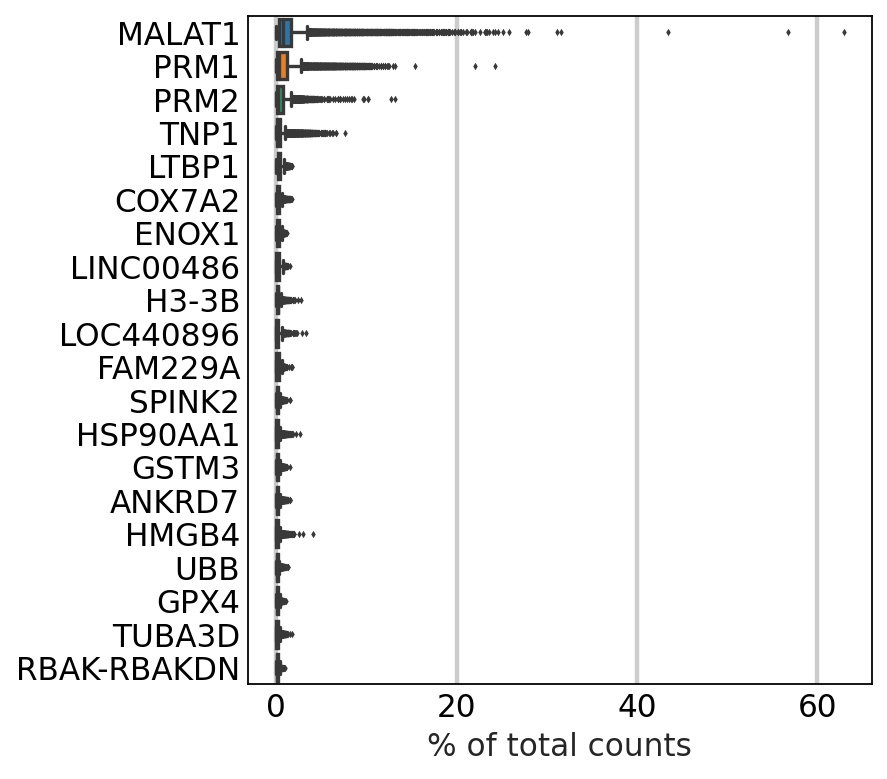

In [208]:
sc.pl.highest_expr_genes(adata_mm, n_top=20, )

Save the percentages of transcripts for highly expressed genes and select a threshold for the values to cut out upper tail. PRM1 and PRM2 are typical for spermatogenesis.

In [209]:
perc_malat = np.sum( adata_mm[:,'MALAT1'].X, 1 ).A1 / np.sum( adata_mm.X, 1 ).A1
adata_mm.obs['perc_MALAT1'] = perc_malat.copy()

In [210]:
adata_mm = adata_mm[adata_mm.obs['perc_MALAT1']<0.15].copy()

In [211]:
adata_mm

AnnData object with n_obs × n_vars = 15485 × 34315
    obs: 'DATASET', 'batch', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'perc_MALAT1'
    var: 'gene_ids', 'feature_types', 'chromosome'
    layers: 'spliced', 'unspliced'

### mtDNA

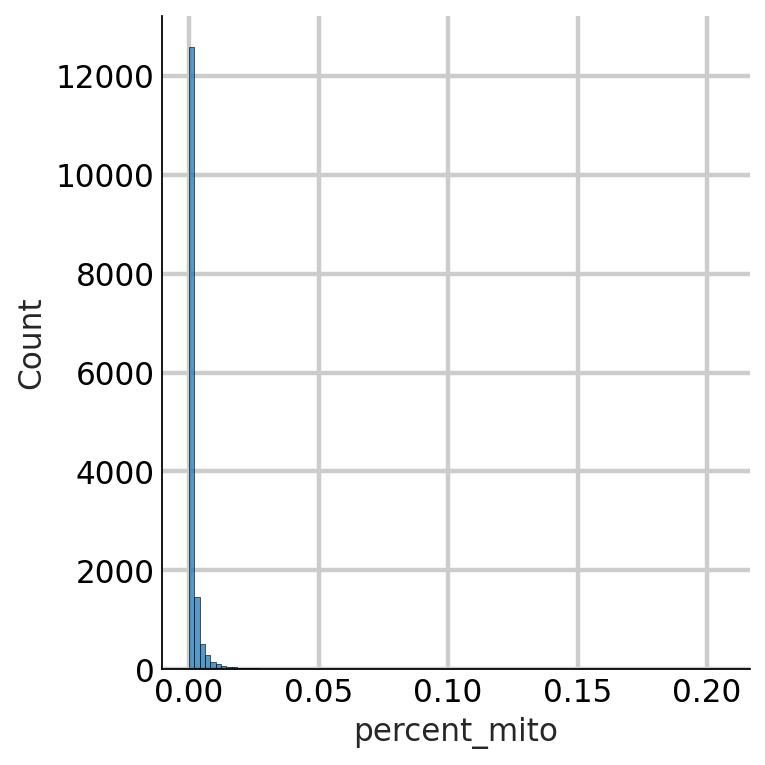

In [212]:
# change dist to hist or dis
sns.displot(adata_mm.obs["percent_mito"], bins=100)

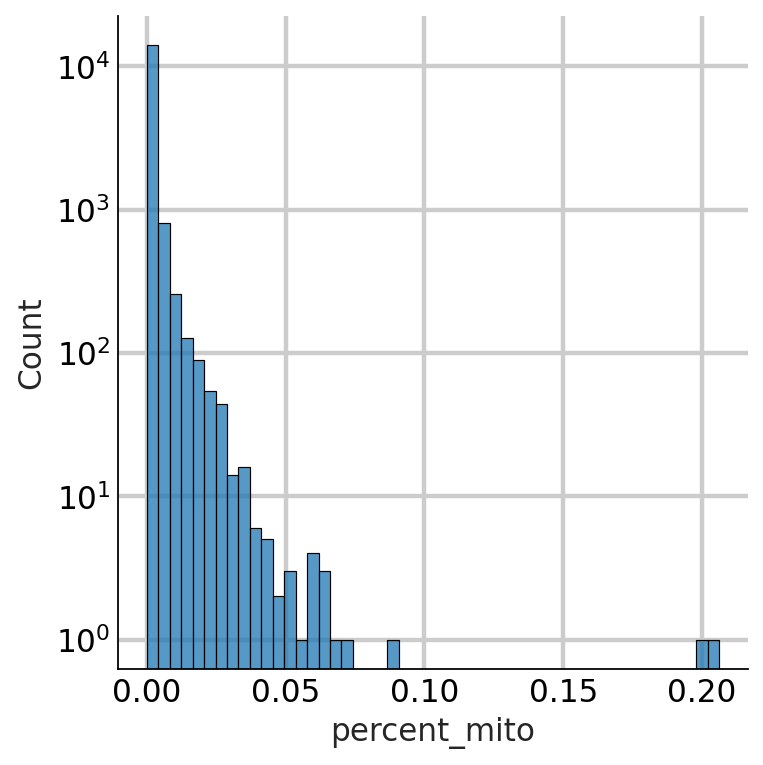

In [213]:
sns.displot(adata_mm.obs["percent_mito"], bins=50, log_scale=(False, True))

In [214]:
# remove high MT perc (standard 10 %)
adata_mm = adata_mm[adata_mm.obs["percent_mito"]<0.1].copy()

In [215]:
adata_mm.shape

(15483, 34315)

### Spliced proportions filter

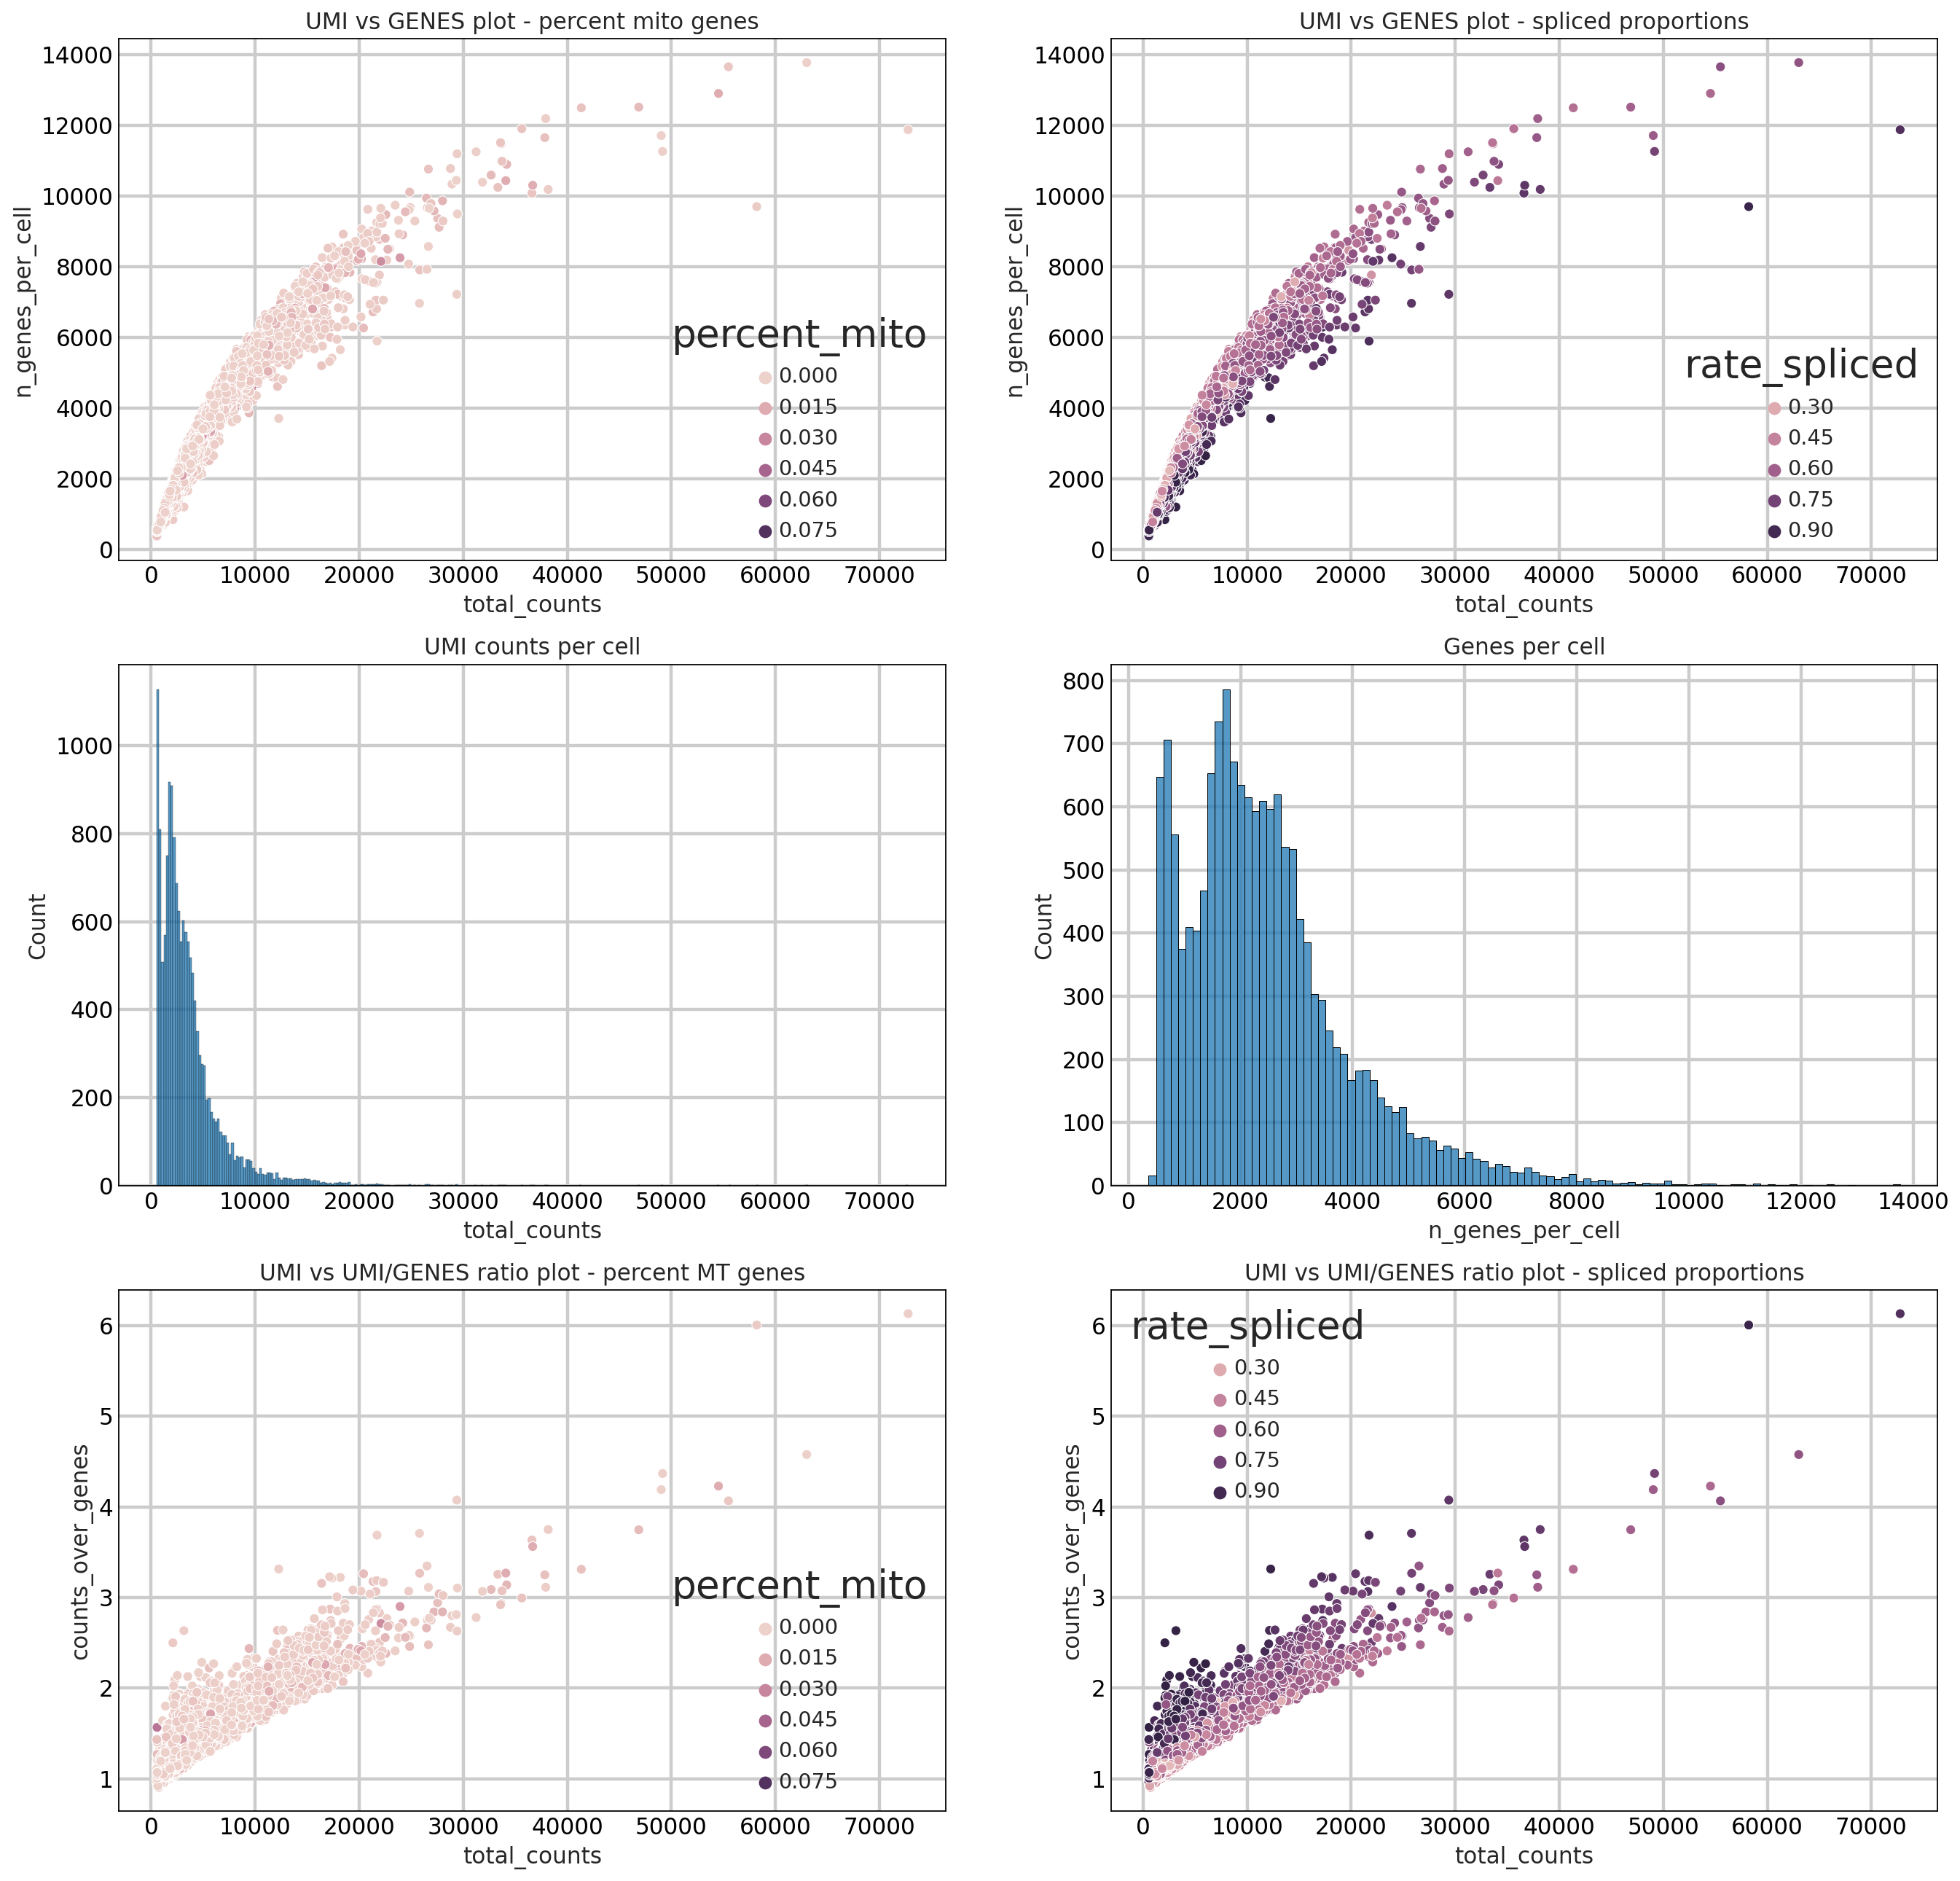

In [216]:
#do some plots of quality measures
plotQC(adata_mm)

<Axes: xlabel='prop_spl', ylabel='Count'>

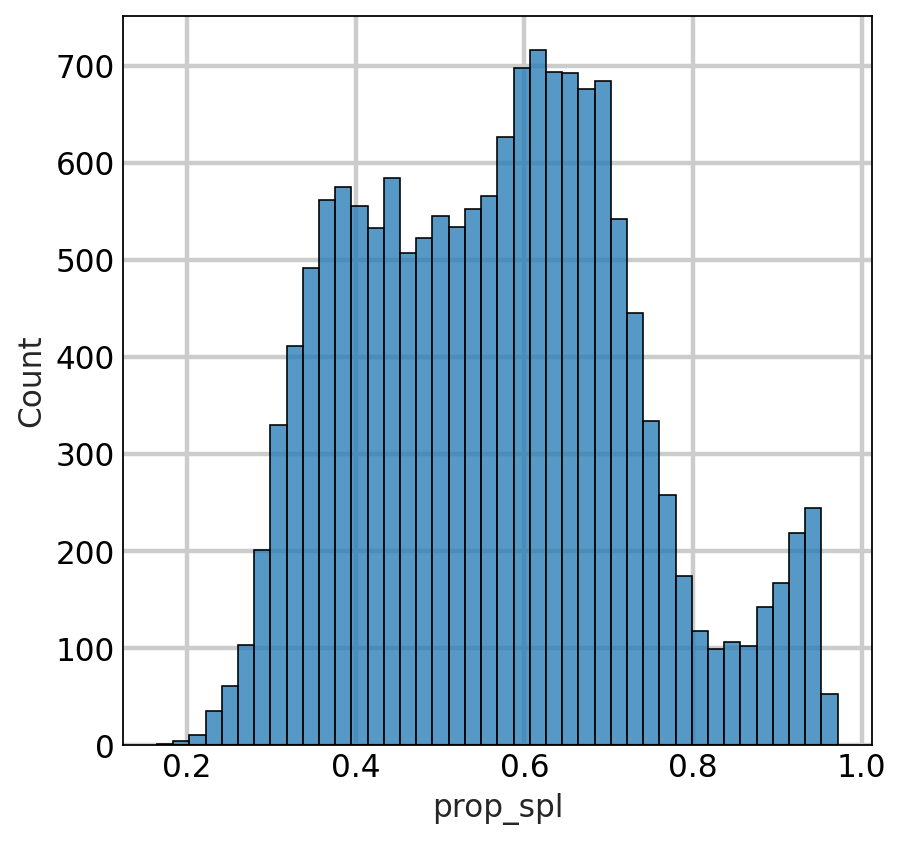

In [217]:
#look at spliced proportions in detail to decide what to remove
plt.rcParams["figure.figsize"] = (6,6)
sns.histplot(adata_mm.obs['prop_spl'])

In [218]:
#spliced proportions filtering. One can avoid being too rough in filtering, the later filtering based on PCA decomposition is going to help removing remaining outliers with spliced proportions out of range (since those cells also show other abnormal quality measures).
prop_spl = .85
print('Removing',adata_mm[adata_mm.obs['prop_spl']>=prop_spl].shape[0],'cells with equal or more than',prop_spl,'spliced proportion')
adata_mm=adata_mm[adata_mm.obs['prop_spl']<prop_spl].copy()

Removing 968 cells with equal or more than 0.85 spliced proportion


In [219]:
adata_mm.shape

(14515, 34315)

In [220]:
sc.pp.filter_cells(adata_mm, min_genes=600)

filtered out 341 cells that have less than 600 genes expressed


In [221]:
sc.pp.filter_cells(adata_mm, max_genes=10000)

filtered out 28 cells that have more than 10000 genes expressed


In [222]:
adata_mm = adata_mm[adata_mm.obs.total_counts < 18000, :]

In [223]:
adata_mm.shape

(14038, 34315)

In [224]:
adata_mm = adata_mm[adata_mm.obs.total_counts > 1000, :]

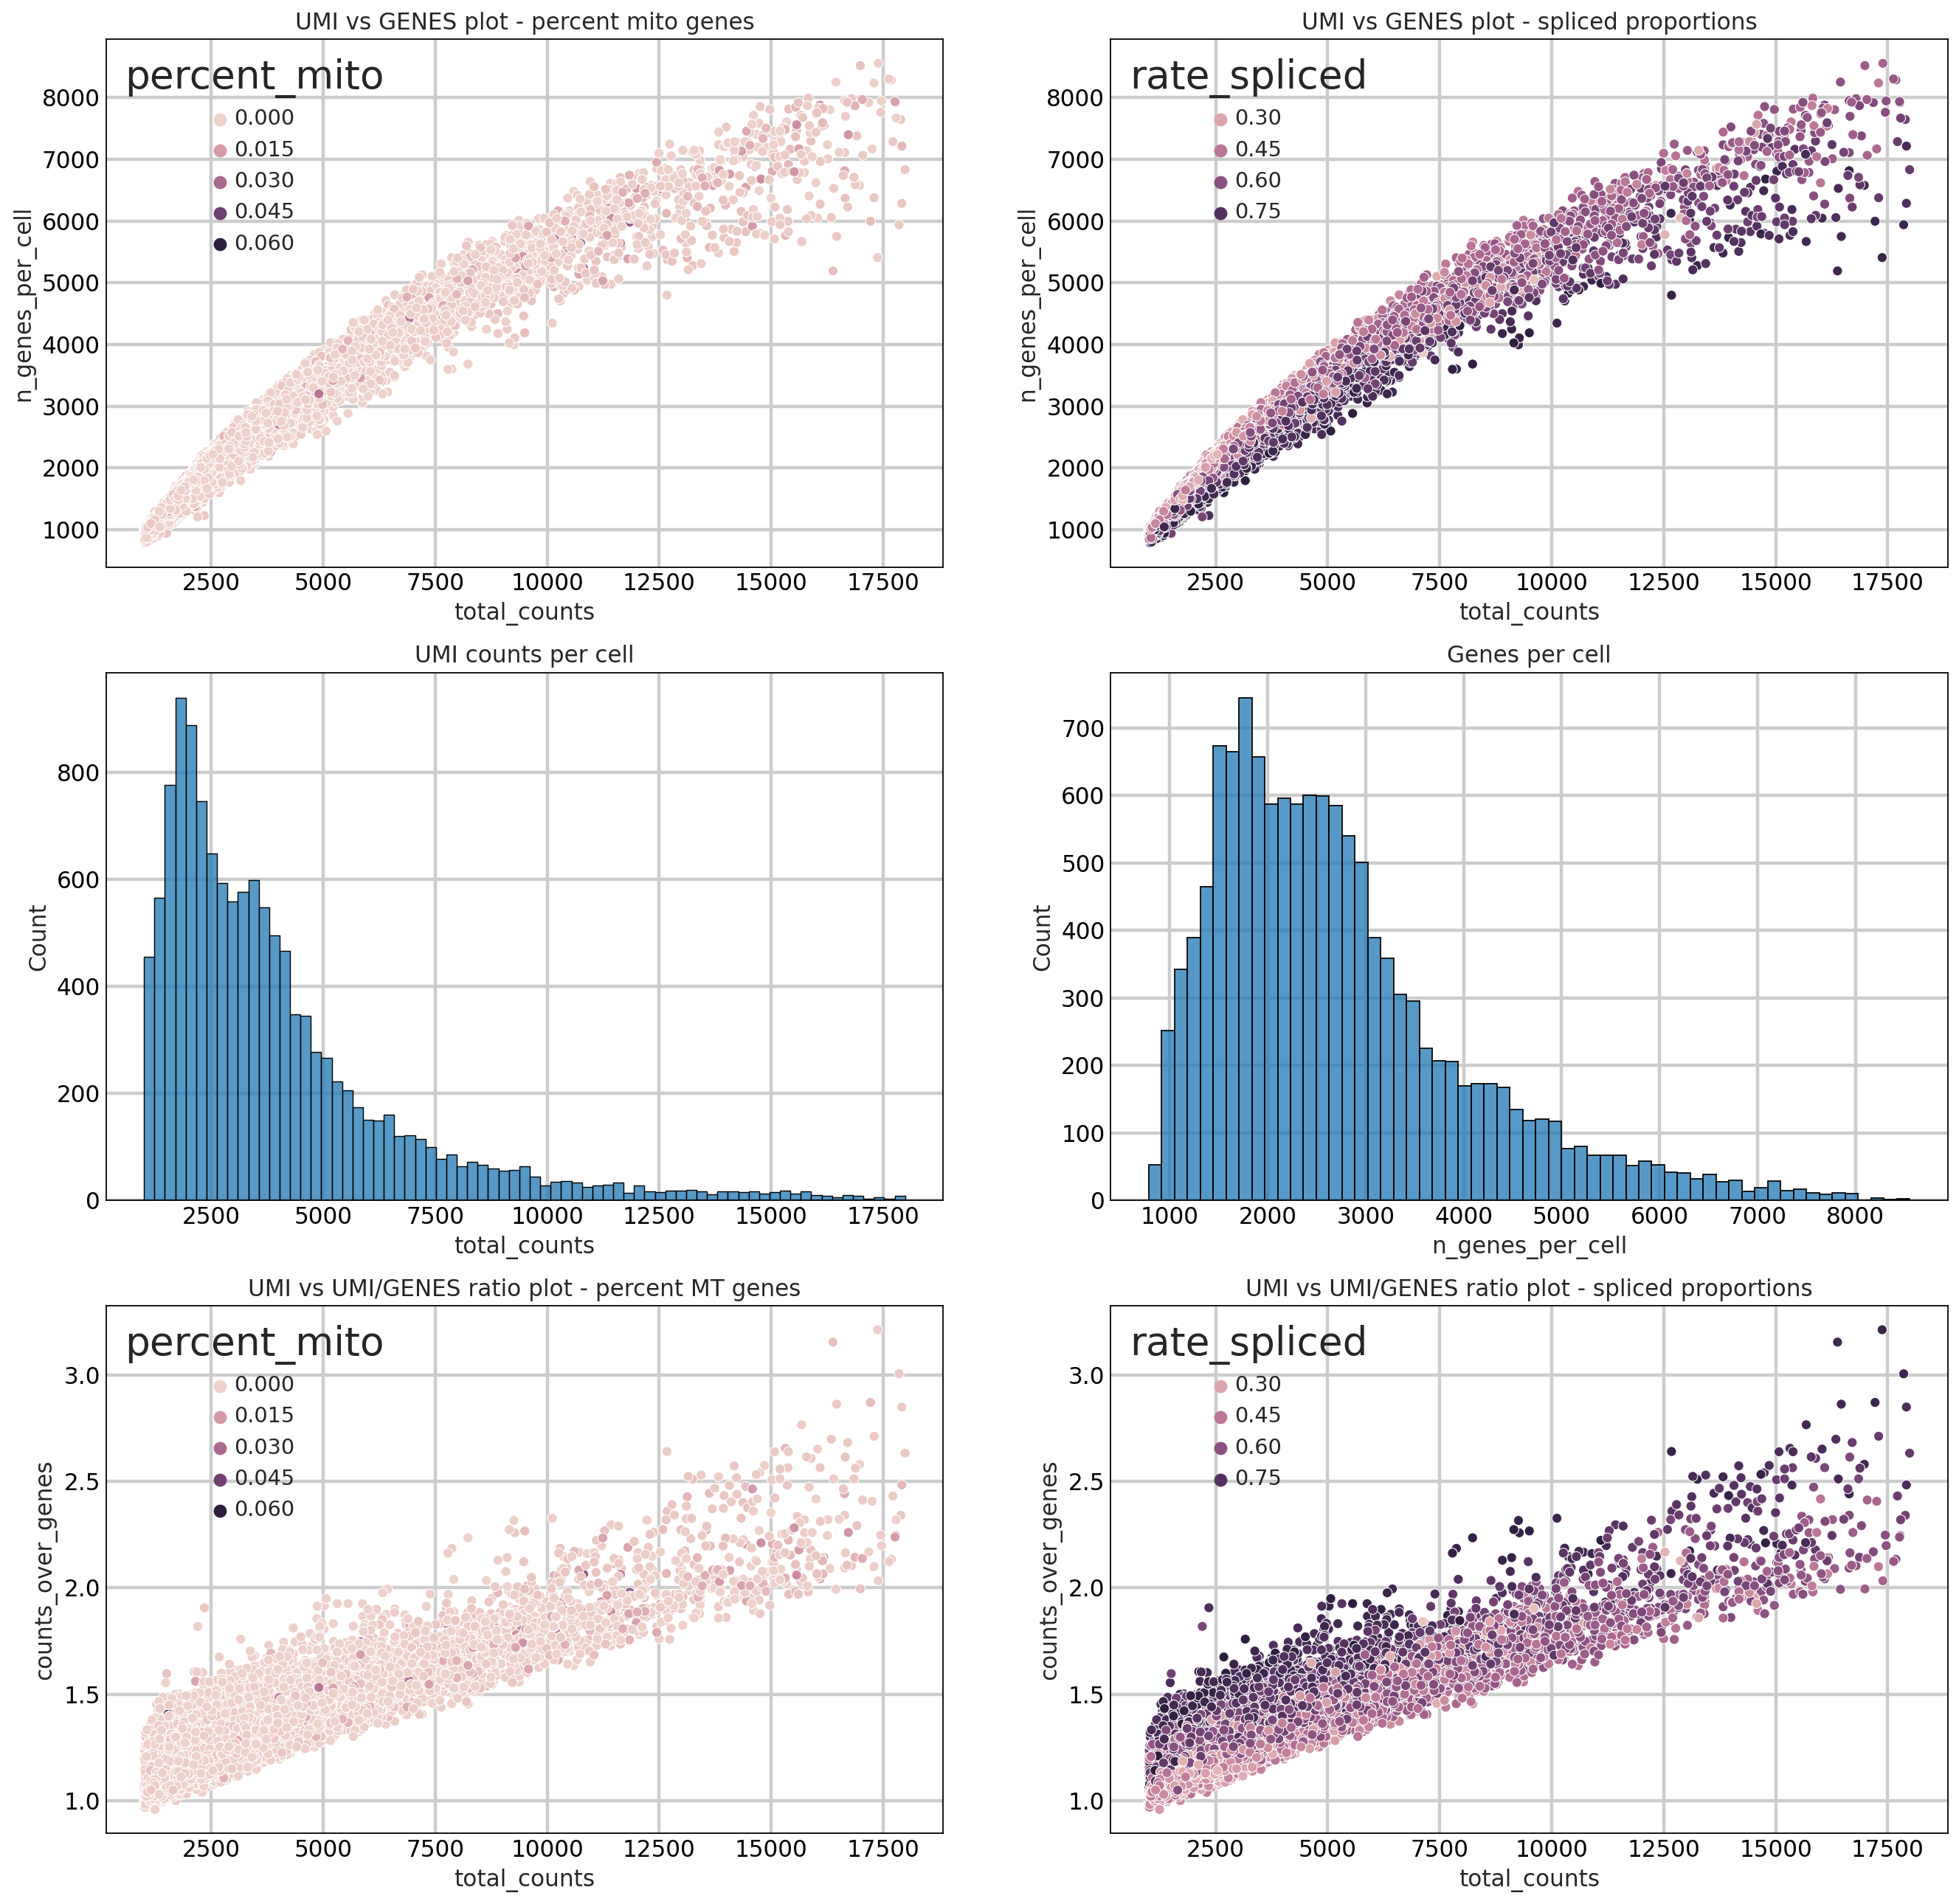

In [225]:
#how it looks after filtering by spliced proportions, gene count and total counts
plotQC(adata_mm)

### Filter out genes seen in less than few cells

In [226]:
sc.pp.filter_genes(adata_mm, min_cells=50)

filtered out 6980 genes that are detected in less than 50 cells


/home/astridkd/miniconda3/envs/scrublet_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [227]:
adata_mm.shape

(12858, 27335)

### Filter out doublets

In [228]:
scrublet(adata_mm, expected_rate=0.06, doublet_score=.2)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.12
Detected doublet rate = 12.8%
Estimated detectable doublet fraction = 67.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 19.0%
Elapsed time: 20.9 seconds
Nr of predicted doublets  1006
Doublets indices saved in adata.obs["predicted_doublets"]


In [229]:
# removing estimated doublets
adata_mm = adata_mm[np.invert(adata_mm.obs['predicted_doublets'])].copy()

In [234]:
adata_mm.layers["raw_counts"] = adata_mm.X.todense()  # Return a dense matrix representation

### Write output

In [ ]:
mkdir -p ./write #make a folder

In [231]:
adata_mm.layers["unspliced"]

<11852x27335 sparse matrix of type '<class 'numpy.float32'>'
	with 22651090 stored elements in Compressed Sparse Row format>

In [235]:
adata_mm.layers["raw_counts"]

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [237]:
adata_mm.layers["raw_counts"] = np.array(adata_mm.layers["raw_counts"]).copy()

In [238]:
#save data
adata_mm.write(adata_out_mm)
# adata_mm.write(write/adata_out_mm)
#adata_s.write(adata_out_s)

# open saved data
# adata = sc.read(adata_out_mm)